# Black Derman Toy Model Calibration 1990

The goal of this notebook is to define a class for calibrating the 1990 Black-Derman-Toy (BDT) model, following the original paper's methodology.

This implementation serves as a prototype, prioritizing clarity over optimization.

Finally, we demonstrate how to use the class to replicate the results from the paper.

In [1]:
import numpy as np
from scipy.special import comb 
from scipy import optimize as opt
import math
import matplotlib.pyplot as plt

In [2]:
class BinomialTree:
    
    """
    This class implements the binomial short rate tree used for interest rate modeling.
    It allows calibration of the model using the Black-Derman-Toy (BDT) methodology and 
    provides methods for pricing Zero-Coupon Bonds (ZCBs) and computing option sensitivities (deltas).
    """
    
    def __init__(self,dt):
        """
        Initializes the binomial tree model.

        Parameters:
        - dt: Time step size in years.
        """
        self.dt=dt
        self.rates = []
        self.T=0
    
    def Print(self):
        """ Prints the binomial tree, displaying short rates at each time step. """
        for time in range(len(self.rates)):
            print(f"{time} -> {self.rates[time]}")
            
    def Price(self,time):
        """
        Computes the price of a zero-coupon bond (ZCB) maturing at a given time step.

        Parameters:
        - time: Maturity in terms of the number of time steps.

        Returns:
        - The computed price of the ZCB.
        """
        price=1
        if(time>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        for t in range(1,time+1,1):
            n=len(self.rates[t-1])-1
            binomial_weights = comb(n, np.arange(n + 1))           
            weighted_sum = np.sum(((1/(1+self.rates[t-1]))**self.dt)* binomial_weights)
            prod=weighted_sum/(2**n)
            price*=prod
        return price
    
    def Price_Bd(self,time):
        """
        Computes the price of a ZCB following only the upward path of the tree.

        This function is primarily used for calibration.

        Parameters:
        - time: Maturity in terms of time steps.

        Returns:
        - The computed price of the ZCB if time is within the calibrated tree, else -1.
        """
        price=1
        if(time>self.T):
            return -1
        for t in range(2,time+1,1):
            n=len(self.rates[t-1][1:])-1
            binomial_weights = comb(n, np.arange(n + 1))           
            weighted_sum = np.sum(((1/(1+self.rates[t-1][1:]))**self.dt)* binomial_weights)
            prod=weighted_sum/(2**n)
            price*=prod
        return price
    def Price_Bu(self,time):
        """
        Computes the price of a ZCB following only the upward path of the tree.

        This function is primarily used for calibration.

        Parameters:
        - time: Maturity in terms of time steps.

        Returns:
        - The computed price of the ZCB if time is within the calibrated tree, else -1.
        """
        price=1
        if(time>self.T):
            return -1
        for t in range(2,time+1,1):
            n=len(self.rates[t-1][:-1])-1
            binomial_weights = comb(n, np.arange(n + 1))           
            weighted_sum = np.sum(((1/(1+self.rates[t-1][:-1]))**self.dt)* binomial_weights)
            prod=weighted_sum/(2**n)
            price*=prod
        return price

    def obj_func_t(self,guess: float, t: int , vol: float ,px_t0: float):
        """
        Defines the objective function for optimizing the short rate guess 

        Parameters:
        - guess: Initial short rate estimate.
        - t: Time step index.
        - vol: Volatility of short rates.
        - px_t0: Target price at time t.

        Returns:
        - The squared deviation from the target price, which needs to be minimized.
        """
        if guess < 0:
            return 1000
        num_nodes = t + 1
        guesses = guess * np.exp(-2 * vol * np.arange(num_nodes)*np.sqrt(self.dt))
        self.rates[t]=guesses
        
        
        price=self.Price(t+1)
        constraint = (px_t0 - price)**2
        return constraint
        
    def Add_Layer(self,Yield,Beta):
        """
        Adds a new layer to the binomial tree, calibrating short rates 
        to match the given yield curve and its associated volatility.

        Parameters:
        - Yield: Yield to maturity for the new time step.
        - Beta: Corresponding short rate volatility.
        """
        
        if(self.T==0):
            self.T+=1
            self.rates.append(np.array([Yield]))
            
        elif(self.T==1):
            error=1
            self.T+=1
            Price=(1/(1+Yield))**(self.T*self.dt)
            self.rates.append(np.array([0,0]))
            res = opt.root(self.obj_func_t, self.rates[self.T-2][0], args=(self.T-1, Beta , Price), method='lm')
            if res.success:
                guess = res.x[0]
                for i  in range(len((self.rates[-1]))):
                    guesses = guess * np.exp(-2 * Beta * np.arange(self.T)*np.sqrt(self.dt))
                    self.rates[-1] = guesses
            else:
                raise Exception(f"Calibration failed!")

        elif(self.T==2):
            self.T+=1
            Price=(1/(1+Yield))**(self.T*self.dt)
            self.rates.append(np.array([0,0,0]))
            error=1
            for sigma_try in np.arange(0,3*Beta+0.001,0.001):
                res = opt.root(self.obj_func_t, self.rates[self.T-2][0], args=(self.T-1, sigma_try , Price), method='lm',options={'xtol': 1e-10})
                if res.success:
                    guess = res.x[0]
                    for i  in range(len((self.rates[-1]))):
                        guesses = guess * np.exp(-2 * sigma_try * np.arange(self.T)*np.sqrt(self.dt))
                        self.rates[-1] = guesses
                else:
                    raise Exception(f"Calibration failed!")
                Bd=self.Price_Bd(self.T)
                Bu=self.Price_Bu(self.T)
                yd=np.sqrt(1/Bd)-1
                yu=np.sqrt(1/Bu)-1
                imp_vol=0.5*np.log(yu/yd)/np.sqrt(self.dt)
                if((imp_vol-Beta)**2<error):
                    error=(imp_vol-Beta)**2
                    best_sigma=sigma_try
                    best_rates=self.rates[-1]
                self.rates[-1]=np.array([0,0,0])
  
            self.rates[-1]=best_rates
        else:
            self.T+=1
            Price=(1/(1+Yield))**(self.T*self.dt)
            self.rates.append(np.zeros(self.T))
            error=1
            for sigma_try in np.arange(0,3*Beta+0.001,0.001):
                res = opt.root(self.obj_func_t, self.rates[self.T-2][0], args=(self.T-1, sigma_try , Price), method='lm',options={'xtol': 1e-10})
                if res.success:
                    guess = res.x[0]
                    for i  in range(len((self.rates[-1]))):
                        guesses = guess * np.exp(-2 * sigma_try * np.arange(self.T)*np.sqrt(self.dt))
                        self.rates[-1] = guesses
                else:
                    raise Exception(f"Calibration failed!")
                Bd=self.Price_Bd(self.T)
                Bu=self.Price_Bu(self.T)
                yd=np.sqrt(1/Bd)-1
                yu=np.sqrt(1/Bu)-1
                imp_vol=0.5*np.log(yu/yd)/np.sqrt(self.dt)
                if((imp_vol-Beta)**2<error):
                    error=(imp_vol-Beta)**2
                    best_sigma=sigma_try
                    best_rates=self.rates[-1]
                self.rates[-1]=np.zeros(self.T)

            self.rates[-1]=best_rates
     
    def Calibrate (self,Yields,Betas):
        """
        Fully calibrates the binomial tree model using given term structure and volatilities.

        Parameters:
        - Yields: List of yield-to-maturity values for each step.
        - Betas: Corresponding list of short rate volatilities.
        """
        if(len(Yields)!=len(Betas)):
            raise Exception(f"Yield and Betas Vector must be same size")
        for i in range(len(Yields)):
            self.Add_Layer(Yields[i],Betas[i])
   
    def ZCB_Tree(self,Bond_Maturity,Notional=1):
        """
        Computes the binomial price tree for a zero-coupon bond.

        Parameters:
        - Bond_Maturity: Maturity of the bond in time steps.
        - Notional: Face value of the bond (default is 1).

        Returns:
        - A binomial tree representing ZCB prices at each node.
        """
        
        if(Bond_Maturity>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        ZCB_Prices=[]
        for time in range(0,Bond_Maturity):
            ZCB_Prices.append(np.zeros(time+1))
        ZCB_Prices.append(np.ones(time+2)*Notional)
        for time in range(Bond_Maturity-1,-1,-1):
            for grade in range(time+1):
                ZCB_Prices[time][grade]=0.5*(ZCB_Prices[time+1][grade]+ZCB_Prices[time+1][grade+1])/(1+self.rates[time][grade])
        return ZCB_Prices
    
    def Pricer (self,Prices,time):
        """
        Computes the price evolution of an arbitrary cash flow structure using backward induction.

        Parameters:
        - Prices: Terminal values at maturity (numpy array).
        - time: Maturity in time steps.

        Returns:
        - A binomial tree representing the value of the cash flow structure at each node.
        """
        if(time>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        Prices_tree=[]
        for t in range(0,time):
            Prices_tree.append(np.zeros(t+1))
        Prices_tree.append(Prices)
        for t in range(time-1,-1,-1):
            for grade in range(t+1):
                Prices_tree[t][grade]=0.5*(Prices_tree[t+1][grade]+Prices_tree[t+1][grade+1])/(1+self.rates[t][grade])
        return Prices_tree
    
    
    def Treasury_Price_Tree (self,Treasury_Maturity,Notional,Fixed_Coupon):
        """
        Computes the price tree for a Treasury bond with fixed coupons.

        Parameters:
        - Treasury_Maturity: Maturity of the bond (time steps).
        - Notional: Face value of the bond.
        - Fixed_Coupon: Periodic coupon payment.

        Returns:
        - A binomial tree representing the price of the Treasury bond.
        """
        if(Treasury_Maturity>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
            
        ZCB_Tree=self.ZCB_Tree(Treasury_Maturity,Notional+Fixed_Coupon)
        Trees=[ZCB_Tree]
        for i in range(Treasury_Maturity-1):
            Trees.append(self.ZCB_Tree(i+1,Fixed_Coupon))
        return(Join_Price_Trees(Trees))
    
    def Treasury_Price_Tree_No_Accured_Interests(self,Treasury_Maturity,Notional,Fixed_Coupon):
        """
        Computes the Treasury bond price tree excluding accrued interest.

        Parameters:
        - Treasury_Maturity: Maturity of the bond (time steps).
        - Notional: Face value of the bond.
        - Fixed_Coupon: Periodic coupon payment.

        Returns:
        - A binomial tree representing the price of the Treasury bond, excluding accrued interest.
        """
        Tree=self.Treasury_Price_Tree(Treasury_Maturity,Notional,Fixed_Coupon)
        for i in range(1,len(Tree)):
            Tree[i]=Tree[i]-Fixed_Coupon
        return Tree
    
        
    def Call_Tree_Pricer_Delta (self,Tree,strike,Maturity):
        """
        Computes the price tree and Delta of a European call option on a given binomial price tree.

        Parameters:
        - Tree: The price tree of the underlying security.
        - strike: Strike price of the option.
        - Maturity: Time step at which the option expires.

        Returns:
        - Price_Tree: A binomial tree representing the price of the call option.
        - Delta: The hedge ratio at the first time step.
        """
        if(Maturity>self.T or len(Tree)>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        Price_Tree=self.Pricer(np.maximum(Tree[Maturity]-strike,0),Maturity)
        Delta=(Price_Tree[1][0]-Price_Tree[1][1])/(Tree[1][0]-Tree[1][1])
        return Price_Tree,Delta
    
    def Put_Tree_Pricer_Delta (self,Tree,strike,Maturity):
        """
        Computes the price tree and Delta of a European put option on a given binomial price tree.

        Parameters:
        - Tree: The price tree of the underlying security.
        - strike: Strike price of the option.
        - Maturity: Time step at which the option expires.

        Returns:
        - Price_Tree: A binomial tree representing the price of the put option.
        - Delta: The hedge ratio at the first time step.
        """
        if(Maturity>self.T or len(Tree)>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        Price_Tree=self.Pricer(np.maximum(-Tree[Maturity]+strike,0),Maturity)
        Delta=(Price_Tree[1][0]-Price_Tree[1][1])/(Tree[1][0]-Tree[1][1])
        return Price_Tree,Delta
    
    def Bond_Call_Price_Tree(self,Option_Maturity,Bond_Maturity,Notional,strike):
        """
        Computes the price tree and Delta of a European call option on a Zero-Coupon Bond (ZCB).

        Parameters:
        - Option_Maturity: Expiry time step of the option.
        - Bond_Maturity: Maturity time step of the ZCB.
        - Notional: Face value of the bond.
        - strike: Strike price of the option.

        Returns:
        - Price_Tree: A binomial tree representing the price of the bond call option.
        - Delta: The hedge ratio at the first time step.
        """

        if(Option_Maturity>self.T or Bond_Maturity>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        ZCB=self.ZCB_Tree(Bond_Maturity,Notional)
        Prices=np.maximum(ZCB[Option_Maturity]-strike*np.ones(Option_Maturity+1),0)
        return self.Pricer(Prices,Option_Maturity)
    
    def Bond_Put_Price_Tree(self,Option_Maturity,Bond_Maturity,Notional,strike):
        """
        Computes the price tree and Delta of a European put option on a Zero-Coupon Bond (ZCB).

        Parameters:
        - Option_Maturity: Expiry time step of the option.
        - Bond_Maturity: Maturity time step of the ZCB.
        - Notional: Face value of the bond.
        - strike: Strike price of the option.

        Returns:
        - Price_Tree: A binomial tree representing the price of the bond put option.
        - Delta: The hedge ratio at the first time step.
        """
        if(Option_Maturity>self.T or Bond_Maturity>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        ZCB=self.ZCB_Tree(Bond_Maturity,Notional)
        Prices=np.maximum(-ZCB[Option_Maturity]+strike*np.ones(Option_Maturity+1),0)
        return self.Pricer(Prices,Option_Maturity)
        
    def plot_binomial_tree(self, title, ylabel, xlabel):
        """
        Plots the binomial tree representation of short rates.

        Parameters:
        - title: Plot title.
        - ylabel: Label for the y-axis.
        - xlabel: Label for the x-axis.
        """
        fig, ax = plt.subplots(figsize=(10, 6))

        max_depth = len(self.rates[-1])
        spacing = 1  

        for time in range(len(self.rates) - 1):  
            current_nodes = len(self.rates[time])
            next_nodes = len(self.rates[time + 1])

            for i in range(current_nodes):
                y_pos = -i * spacing + (current_nodes - 1) * spacing / 2  
                next_y_pos_up = -(i * spacing) + (next_nodes - 1) * spacing / 2
                next_y_pos_down = -(i + 1) * spacing + (next_nodes - 1) * spacing / 2

                ax.text(time * self.dt, y_pos, f"{self.rates[time][i]:.4f}", 
                        fontsize=10, ha='center', va='center', color='black',
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

                ax.plot([time * self.dt, (time + 1) * self.dt], [y_pos, next_y_pos_up], 'k-', lw=1)
                ax.plot([time * self.dt, (time + 1) * self.dt], [y_pos, next_y_pos_down], 'k-', lw=1)

        last_time = (len(self.rates) - 1) * self.dt
        for i in range(len(self.rates[-1])):
            y_pos = -i * spacing + (max_depth - 1) * spacing / 2  
            ax.text(last_time, y_pos, f"{self.rates[-1][i]:.4f}",  fontsize=10, ha='center', va='center', color='black',bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_yticks([])  
        ax.grid(True, linestyle='--', alpha=0.6)

        ax.legend([f"Time step = {self.dt}"], loc="upper left", frameon=True)

        plt.show()

def Join_Price_Tree(Tree1,Tree2):
    """
    Merges two binomial trees by summing corresponding nodes. If one tree is longer, 
    the remaining nodes from the longer tree are copied.

    Parameters:
    - Tree1: First binomial price tree (list of numpy arrays).
    - Tree2: Second binomial price tree (list of numpy arrays).

    Returns:
    - A new binomial tree representing the sum of Tree1 and Tree2.
    """
    Tree_new=[]
    t1=min(len(Tree1),len(Tree2))
    t2=max(len(Tree1),len(Tree2))
    for time in range(t1):
        Tree_new.append(np.zeros(time+1))
        for grade in range(time+1):
            Tree_new[time][grade]=Tree1[time][grade]+Tree2[time][grade]
    for time in range(t1,t2):
        Tree_new.append(np.zeros(time+1))
        for grade in range(time+1):
            if(len(Tree1)>len(Tree2)):
                Tree_new[time][grade]=Tree1[time][grade]
            else:
                Tree_new[time][grade]=Tree2[time][grade]

    return Tree_new

def Join_Price_Trees(Trees):
    """
    Merges multiple binomial trees into a single tree by summing corresponding nodes.

    Parameters:
    - Trees: A list of binomial price trees (each tree is a list of numpy arrays).

    Returns:
    - A single binomial tree representing the sum of all input trees.

    Raises:
    - Exception if fewer than two trees are provided.
    """
    if(len(Trees)<2):
        raise Exception("You need at least two trees to join")
    starting_Tree=Trees[0]
    for i in range(1,len(Trees)):
        starting_Tree=Join_Price_Tree(starting_Tree,Trees[i])
    return starting_Tree

def plot_binomial_tree(tree, dt, title, ylabel, xlabel):
    """
    Plots a binomial tree, displaying nodes with associated numerical values.

    Parameters:
    - tree: The binomial tree to be plotted (list of numpy arrays).
    - dt: Time step size.
    - title: Title of the plot.
    - ylabel: Label for the y-axis.
    - xlabel: Label for the x-axis.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    max_depth = len(tree[-1])
    spacing = 1  

    for time in range(len(tree) - 1):  
        current_nodes = len(tree[time])
        next_nodes = len(tree[time + 1])

        for i in range(current_nodes):
            y_pos = -i * spacing + (current_nodes - 1) * spacing / 2  
            next_y_pos_up = -(i * spacing) + (next_nodes - 1) * spacing / 2
            next_y_pos_down = -(i + 1) * spacing + (next_nodes - 1) * spacing / 2

            ax.text(time * dt, y_pos, f"{tree[time][i]:.4f}", 
                    fontsize=10, ha='center', va='center', color='black',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

            ax.plot([time * dt, (time + 1) * dt], [y_pos, next_y_pos_up], 'k-', lw=1)
            ax.plot([time * dt, (time + 1) * dt], [y_pos, next_y_pos_down], 'k-', lw=1)

    last_time = (len(tree) - 1) * dt
    for i in range(len(tree[-1])):
        y_pos = -i * spacing + (max_depth - 1) * spacing / 2  
        ax.text(last_time, y_pos, f"{tree[-1][i]:.4f}",  fontsize=10, ha='center', va='center', color='black',bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yticks([])  
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.legend([f"Time step = {dt}"], loc="upper left", frameon=True)

    plt.show()




    
    

We first calibrate the model to the Yield and Yield Voltility data given in the paper

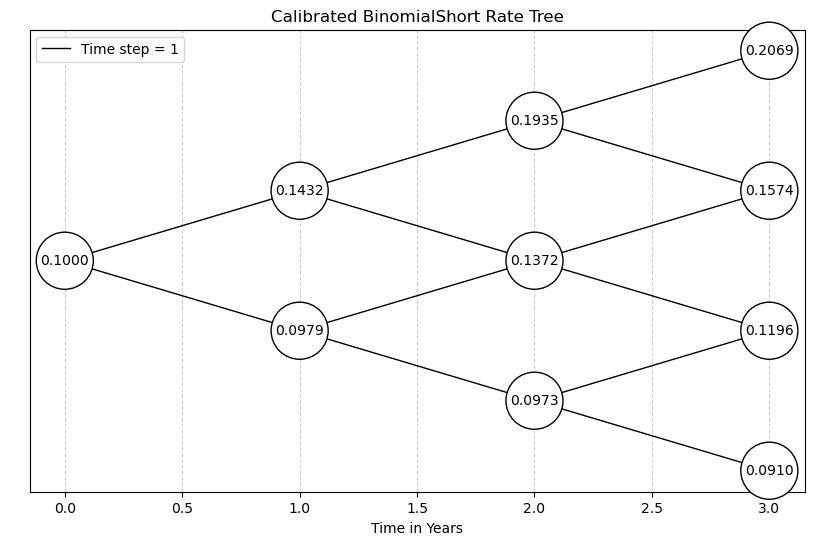

In [3]:
tree=BinomialTree(1)
tree.Calibrate([0.1,0.11,0.12,0.125],[0.2,0.19,0.18,0.17])
tree.plot_binomial_tree("Calibrated BinomialShort Rate Tree", " " ,"Time in Years")

Now we build the Price Trees of the zero coupon bonds for all the passible maturities (form T=1 to T=4) 

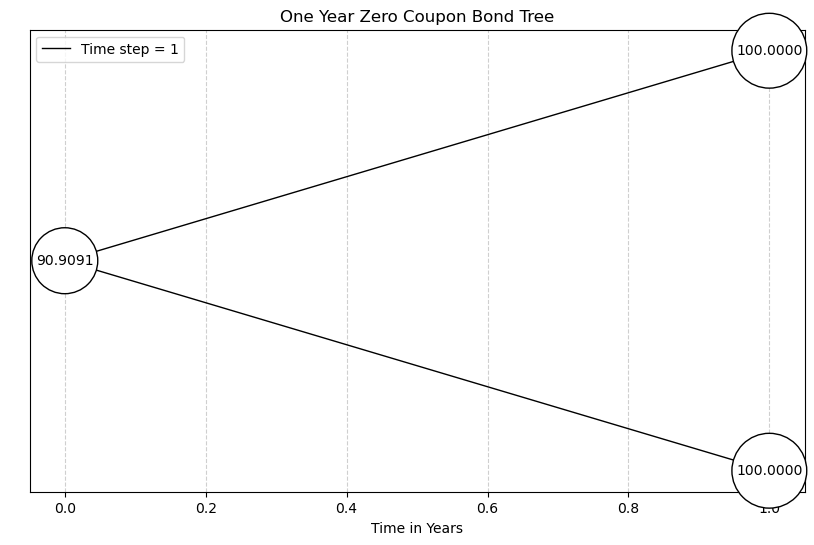

In [4]:
ZCB1y=tree.ZCB_Tree(1,100)
plot_binomial_tree(ZCB1y,1,"One Year Zero Coupon Bond Tree"," " ,"Time in Years")

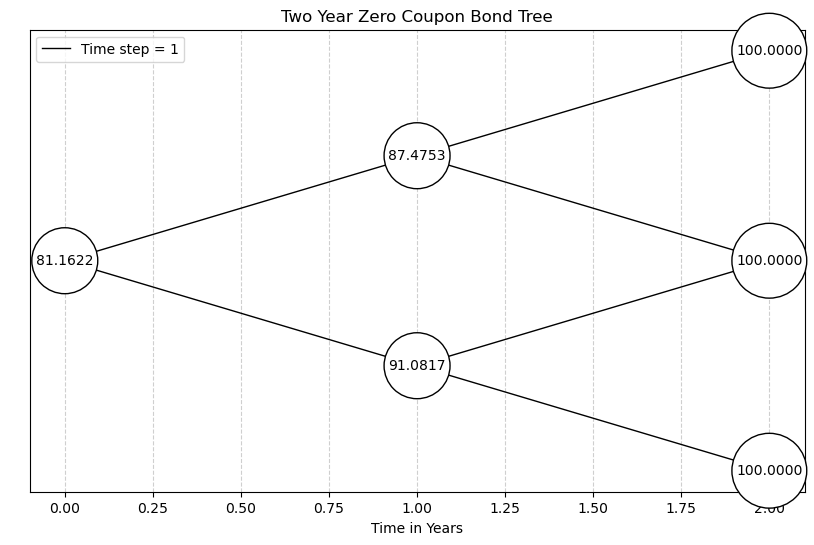

In [5]:
ZCB2y=tree.ZCB_Tree(2,100)
plot_binomial_tree(ZCB2y,1,"Two Year Zero Coupon Bond Tree"," " ,"Time in Years")

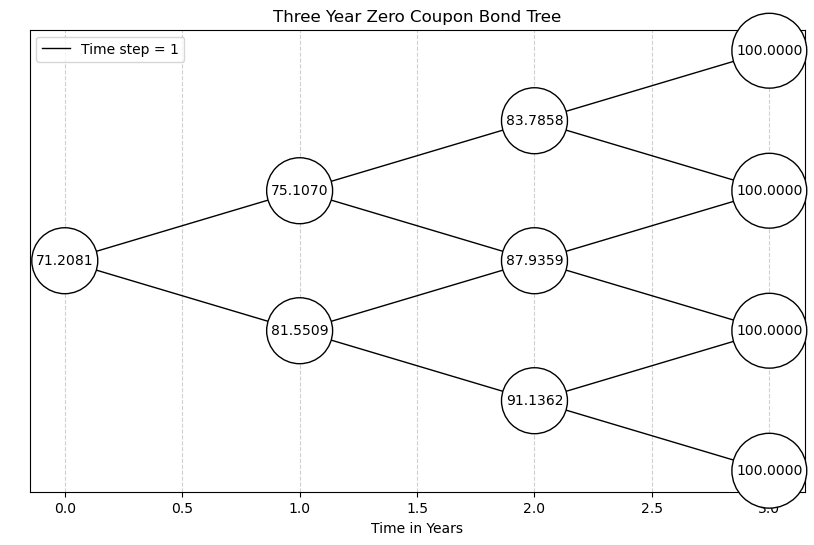

In [6]:
ZCB3y=tree.ZCB_Tree(3,100)
plot_binomial_tree(ZCB3y,1,"Three Year Zero Coupon Bond Tree"," " ,"Time in Years")

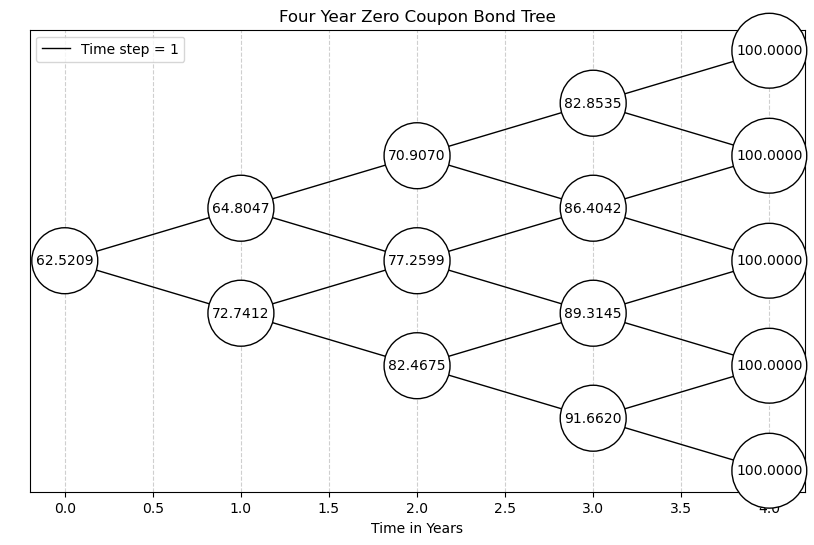

In [7]:
ZCB4y=tree.ZCB_Tree(4,100)
plot_binomial_tree(ZCB4y,1,"Four Year Zero Coupon Bond Tree"," " ,"Time in Years")

No we Build the Price Tree of the three year treasury with a 10$ fixed coupon rate with and without Accured interests

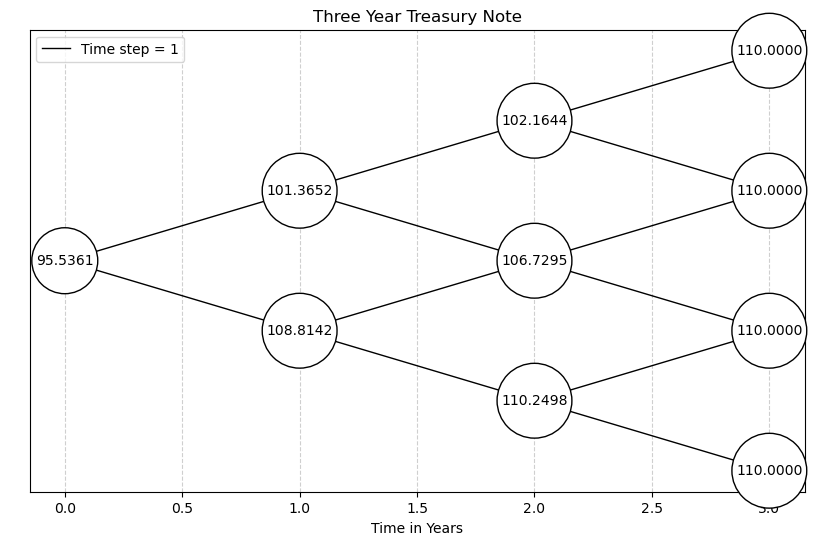

In [8]:
Treasury3y=tree.Treasury_Price_Tree(3,100,10)
plot_binomial_tree(Treasury3y,1,"Three Year Treasury Note"," " ,"Time in Years")

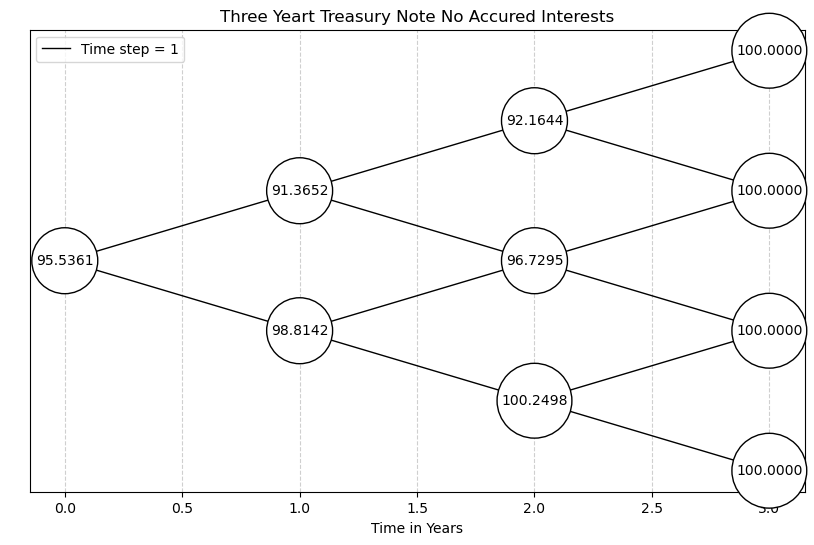

In [9]:
Treasury_no3y=tree.Treasury_Price_Tree_No_Accured_Interests(3,100,10)
plot_binomial_tree(Treasury_no3y,1,"Three Yeart Treasury Note No Accured Interests"," " ,"Time in Years")

We now construct the price tree for a call option on a 3-year Treasury bond with a 2-year maturity and a strike price of 95. Additionally, we compute the corresponding Delta.

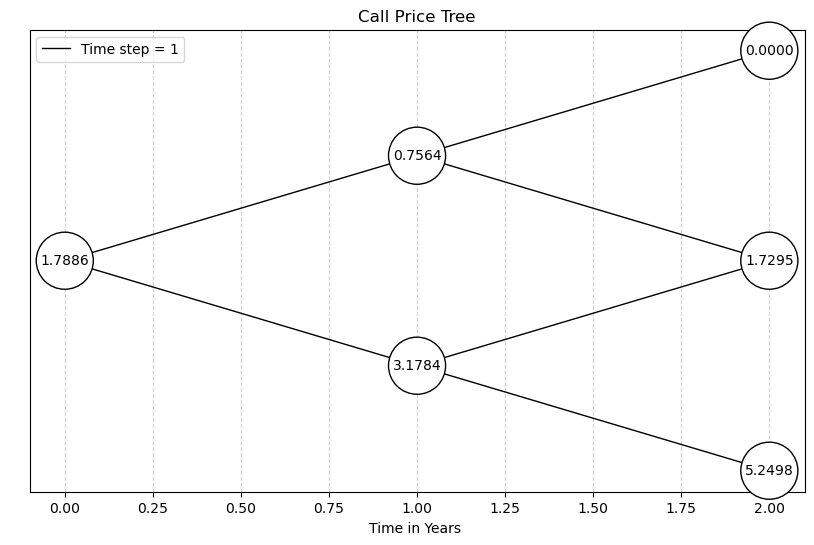

The Delta of the Call is 0.3251


In [10]:
Call_Tree,Delta=tree.Call_Tree_Pricer_Delta(Treasury_no3y,95,2)
plot_binomial_tree(Call_Tree,1,"Call Price Tree"," ","Time in Years ")
print(f"The Delta of the Call is {Delta:.4f}")

We can do the same with the Put

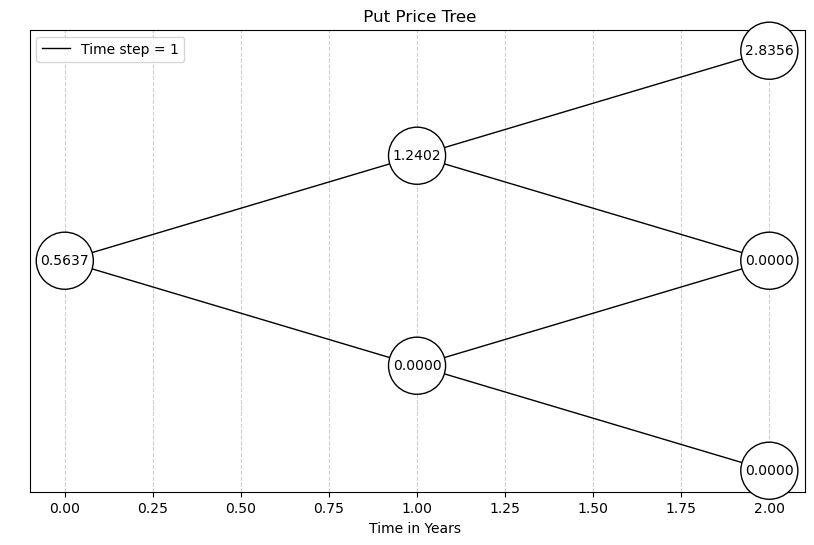

The Delta of the Put is -0.1665


In [11]:
Put_Tree,Delta=tree.Put_Tree_Pricer_Delta(Treasury_no3y,95,2)
plot_binomial_tree(Put_Tree,1," Put Price Tree"," ","Time in Years ")
print(f"The Delta of the Put is {Delta:.4f}")